In [8]:
import json, pathlib
import tqdm
import pandas as pd
import gzip
from collections import defaultdict
%reload_ext autoreload 
%autoreload 2


In [9]:
# data prep
bbox_dir = '/mnt/sw/data/vln/BBoxes_v2' 
bbox_dir = pathlib.Path(bbox_dir)
category_mapping_dir = pathlib.Path('/mnt/sw/data/vln/category_mapping.tsv')
filter_out_objects = {'misc', 'objects','unlabeled','void','wall', 'appliances', 'ceiling', 'floor', "lighting", "door", "railing", "stairs", "window", "shelving"}
category_mapping = pd.read_csv(category_mapping_dir, sep='\t')

In [10]:
def read_gz_jsonlines(filename):
    # *
    data = []
    with open(filename, 'rb') as f:
        for args in map(json.loads, gzip.open(f)):
            data.append(args)
    return data

def load_json(filename):
    # *
    with open(filename) as f:
        data = json.load(f)
    return data

# TOOD maybe just use object index?
def get_mpcat40_from_raw_category(old_cat: str, category_mapping=category_mapping) -> str:
    if '#' in old_cat:
        old_cat = old_cat.replace("#", " ")

    new_cat = category_mapping[category_mapping['raw_category'] == old_cat]['mpcat40'].tolist()[0]
    if "_" in new_cat:
        new_cat = new_cat.replace("_", " ")
    return new_cat


In [11]:
# (px, py, pz, a0x, a0y, a0z, a1x, a1y, a1z, r0, r1, r2) define the center, axis directions, and radii of an oriented bounding box, 
#     height is the distance from the floor, and 
#     0 is a value that can be ignored.


In [12]:
scan_viewpoints = defaultdict(lambda: defaultdict(list))
for box in tqdm.tqdm(bbox_dir.glob('*.json')):
    result = load_json(box)
    scan = box.stem.split('_')[0]
    name = box.stem.split('_')[1]
    if result[name] != {}:
        scan_viewpoints[scan][name] = result[name]

TypeError: first argument must be callable or None

In [6]:
viewpoints.keys()

dict_keys(['85599a90376043339b55e424eeb9aeab', '3848b1ba65fa49308c3d0a79f63782b3', 'a5de243ba6ba4f06a669c82a84962d05', '9ef575278a80426aa83858b08bb1a963', '38120419ee5c40eaabd9719a538d1550', 'fa22eae3a3bd4af98424def01751d2f6', '0e6e6b0332d745178dd37fc1d4a710a2', '7fc9b77a67794c9385ee1a2ba579cc92', '9e665c259d394dff909391bbb1164293', '010c38b965f843419fce46d0156b2c16', '18b3ba6951f643c89caceda38f7c5404', '924e3186b0094263919f96914de0a8f3', '41fef0822d3f4b5581d3954dbcacad41', '3e3c920169f74249a55c08e978438ef4', '84e7537aa70547c29b56679ada0fcbf4', 'a728d2eef41b449f82357899de802dd3', 'fa019ebdccf5448a82de2f9e23a9bbd2', 'ba116ef8a4774259aa94dafe327d0ff0', 'bb2e8d90f43a444fb60665f2f41996ce', '5a5bb6f6a2ae49ddbb9260d0602230b5', 'e1b452079ec54f63b3cfa0d3827e6e16', 'fc54060df0b540cca6c490e2524ee4e3', 'e2eea35b69824760b11d1815a52cb72c', 'b8d68745ab054a2da8a82de45fce8cef', '97693dd5ad3146709e78c49ff61d389e', '70e556fba331422596d4473a452ba62f', '71e319685a2b4acca9fe0697215daba8', '28cd285e6d5545dd

In [ ]:
viewpoint2objectids = defaultdict(set)
for vp, objs in viewpoints.items():
    for obj_id, obj in objs.items():
        

In [16]:
# vp_filtered ={vp: [{
#     obj_id: obj_id,
#     obj_category: obj_category,
#     visible_pos: visible_pos,
#     bbox: bbox
# }]
# }
coverage = 1/8
vp_filtered = defaultdict(list) 
for vp, objs in viewpoints.items():
    for obj_id, obj_info in objs.items():
        index_box = [(i, box) for i, box in enumerate(obj_info['bbox2d']) if box[2] * box[3] / (640 * 480) >= coverage] 
        filtered_visible_pos = [obj_info['visible_pos'][i] for i, _ in index_box]
        filtered_bbox = [obj_info['bbox2d'][i] for i, _ in index_box]
        if obj_info['name'] in filter_out_objects or filtered_visible_pos == []:
            continue
        vp_filtered[vp].append({
            'obj_id': obj_id,
            'obj_category': obj_info['name'],
            'visible_pos': filtered_visible_pos,
            'bbox': filtered_bbox
        })


In [17]:
all_visible_pos = [vp_info['visible_pos'] for vp, objs in vp_filtered.items() for vp_info in objs]

In [18]:
average_visible_view = sum([len(item) for item in all_visible_pos])/ len(all_visible_pos)

In [19]:
average_visible_view

6.262691912740752

In [20]:
average_object_viewpoint = sum([len(objs) for vp, objs in vp_filtered.items()])/ len(vp_filtered)

In [21]:
average_object_viewpoint

7.632036700755042

In [22]:
rxr_data_path = pathlib.Path('/mnt/sw/data/vln/traj/data/RxR/')
train = read_gz_jsonlines(rxr_data_path/'rxr_train_guide.jsonl.gz')
train_filtered = [item for item in train if item['language'] == 'en-US']

In [23]:
traj_nums = []
for item in train_filtered:
    traj_object_num = 0
    for vp in item['path']:
        if vp not in vp_filtered:
            print(vp)
            continue
        traj_object_num += len(vp_filtered[vp])
    traj_nums.append(traj_object_num)
    
        

b814285591cc43f799874da54f847a54
72b6cd6714a54cb1895409997cb66388
65a868262eb74921b6a6792baa995ddd
a10ec4d9533e4244846a72a7942ee6e5
0c859512f50540e185fcc64323cf87f4
e8bf4bb10201420c844f77680ce0e481
fbd7f3d338eb4ff883275a1c54e61bd9
9b9d929b88994a0eaf69501c2cab3444
7c3b9e689c014d5483dcee581d6c53f5
8a3c83d4c42842c8a60866868b7730a4
5dfe8adbc3794bebafeedcd832b04ea4
d6fc111b6fad4cd0813e2cf3706c3945
071ca188c1b7423c947607cc794e9f72
7f5f4e3055ed47648524fc475bafda6f
64fa4996e32f46769853bc37640a97c3
ea4298ce6f094758ab87d303f2c1a3f3
626c0f49c8cb4d9b93a19215f540d8c7
455c874aa7b949a2bf202a683e1061de
b2295a9f6d6449b3901838eb6ba109ff
b2295a9f6d6449b3901838eb6ba109ff
455c874aa7b949a2bf202a683e1061de
86746af81a6d40be9393a8ed6810598a
3a59799301704bfbbcc96922e94c306a
684c5856cff5465a8ab3c35b6ffa355c
0c859512f50540e185fcc64323cf87f4
e8bf4bb10201420c844f77680ce0e481
1962d6bb7af4424c9902b0246ba766b8
fe9dd44381fe4a4f8d329ddf3d8582ac
1962d6bb7af4424c9902b0246ba766b8
c967dad1b34d45308a0c6c909f19620b
6a9a877ceb

In [24]:
len(train_filtered)

8816

In [25]:
average_attackable = sum(traj_nums)/len(traj_nums)

In [26]:
average_attackable

69.2026996370236

In [27]:
# What number of trajectory associated with an object instance.

In [28]:
trajectory_obj_list = defaultdict(set)
for item in tqdm.tqdm(train_filtered):
    for vp in item['path']:
        object_ids = [obj_info['obj_id'] for obj_info in vp_filtered[vp]]
        trajectory_obj_list[vp].update(object_ids)

100%|██████████| 8816/8816 [00:00<00:00, 109458.30it/s]


In [29]:
object_id2obj_name = defaultdict(list)
for vp, objs in tqdm.tqdm(vp_filtered.items()):
    for obj_info in objs:
        if obj_info['obj_id'] not in object_id2obj_name:
            object_id2obj_name[obj_info['obj_id']].append(obj_info['obj_category'])
        elif obj_info['obj_id'] != object_id2obj_name[obj_info['obj_id']][0]:
            object_id2obj_name[obj_info['obj_id']].append(obj_info['obj_category'])


        # else:
        #     try:
        #         assert object_id2obj_name[obj_info['obj_id']] == obj_info['obj_category']
        #     except AssertionError:
        #         print(object_id2obj_name[obj_info['obj_id']], obj_info['obj_category'])
        #         raise AssertionError

100%|██████████| 10531/10531 [00:00<00:00, 320074.02it/s]


In [37]:
object_cat2trajectory_num = defaultdict(lambda: 0)

In [38]:
object_cat2path_list = defaultdict(list)

In [39]:
for item in tqdm.tqdm(train_filtered):
    object_cat = set()
    for vp in item['path']:
        for obj_info in vp_filtered[vp]:
            obj_cat = get_mpcat40_from_raw_category(obj_info['obj_category'])
            object_cat.add(obj_cat)
    for cat in object_cat:
        object_cat2trajectory_num[cat] += 1
        object_cat2path_list[cat].append(item['path'])
    

  0%|          | 0/8816 [00:00<?, ?it/s]

100%|██████████| 8816/8816 [01:16<00:00, 115.18it/s]


In [40]:
object_cat2trajectory_num

defaultdict(<function __main__.<lambda>()>,
            {'picture': 6124,
             'sink': 2010,
             'objects': 4983,
             'cabinet': 5961,
             'towel': 599,
             'curtain': 3829,
             'door': 8035,
             'bathtub': 1346,
             'window': 3460,
             'shelving': 3801,
             'railing': 3720,
             'mirror': 3772,
             'cushion': 1780,
             'seating': 1451,
             'lighting': 2514,
             'ceiling': 3317,
             'table': 6698,
             'bed': 3936,
             'misc': 5052,
             'wall': 3183,
             'tv monitor': 1895,
             'sofa': 4075,
             'fireplace': 1904,
             'column': 2014,
             'stool': 877,
             'appliances': 1794,
             'counter': 3096,
             'chair': 6301,
             'chest of drawers': 2331,
             'blinds': 318,
             'floor': 2034,
             'unlabeled': 196,
            

In [34]:
len(object_id2obj_name)

1842

In [33]:
len([1 for _, item in object_id2obj_name.items() if len(item) > 1])

1713

In [ ]:
# on average, for each type object, what is the number of trajectories that contain it?

#! ISSUE 
- [ ] many names to one object id
There are 1000 "object ids"?

In [47]:
set_of_ids = {int(v) for v in object_id2obj_name.keys()}

In [48]:
set_of_ids = sorted(list(set_of_ids))

In [49]:
set_of_ids

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [20]:
trajectory_obj_list

defaultdict(set,
            {'4471fcf26b3847ed88ce41eca5ecb13d': {'830', '843', '856'},
             'b2b0b597ef2f4a1c86cbbe335dc2dcc1': {'830',
              '850',
              '851',
              '856',
              '863'},
             '16708c282c26467e8e36cc00812c289c': {'850',
              '851',
              '856',
              '861',
              '863',
              '867',
              '868'},
             '60ce99b0264148c09db7ef836ad77e3f': {'516',
              '524',
              '545',
              '551',
              '552',
              '553',
              '566',
              '574'},
             'dd83fb40a2e14ac99de9fe9bcfaf44df': {'516', '524', '545', '551'},
             'dfe1f8e8b58d4da49f0c73516e7a4b67': {'516', '524', '551', '638'},
             '1838a8fb8e9f48cebcd079d5373cba02': {'502',
              '516',
              '524',
              '551',
              '638',
              '640',
              '643'},
             '65683a5cc3564769947019eb

In [10]:
# for each type of object, what is the number of trajectories that contain it?

In [ ]:
for 

# more serious investigationl with mattport data than reverie

In [50]:
data_dir = pathlib.Path('/Users/zijiao/home/research/test/house_segmentations')

In [51]:
fsegs = load_json(data_dir/'r1Q1Z4BcV1o.fsegs.json')

In [53]:
fsegs.keys()

dict_keys(['elementType', 'segIndices'])

In [54]:
semseg = load_json(data_dir/'r1Q1Z4BcV1o.semseg.json')

In [56]:
semseg.keys()

dict_keys(['segGroups'])

In [9]:
from pytorch3d.io import IO

In [2]:
pwd

'/home/zijiao/research/pytorch_rend'

In [7]:
data_path = pathlib.Path('mnt/sw/data/vln')

In [8]:
mesh = IO().load_mesh(data_path/'test/r1Q1Z4BcV1o/house_segmentations/r1Q1Z4BcV1o.ply')

FileNotFoundError: [Errno 2] No such file or directory: 'mnt/sw/data/vln/test/r1Q1Z4BcV1o/house_segmentations/r1Q1Z4BcV1o.ply'

In [ ]:
%reload_ext autoreload 
%autoreload 2

In [39]:
from pytorch3d.io.ply_io import _load_ply_raw
from iopath.common.file_io import PathManager
path_manager = PathManager()
f = '/mnt/sw/data/vln/test/r1Q1Z4BcV1o/house_segmentations/r1Q1Z4BcV1o.ply'
header, elements = _load_ply_raw(f, path_manager=path_manager)
face = elements.get("face", None)
z = [[x[0], x[2]] for x in face]
len(z)
import numpy as np
import torch
from pytorch3d.renderer.mesh.textures import TexturesVertex
from pytorch3d.structures import Meshes
from render.utils import get_device

vertex = elements['vertex'][0][:, :3]

vertex_torch = torch.tensor(vertex.copy())
del vertex
face = np.vstack([item[0] for item in elements['face']])
face = torch.tensor(face.copy())
texture = torch.tensor(elements['vertex'][1]).unsqueeze(0)/255.0
textureV = TexturesVertex(texture)
device = get_device()
mesh = Meshes(
    verts=[vertex_torch.to(device)],
    faces=[face.to(device)],
    textures=textureV.to(device),
    )

In [11]:
from pytorch3d.vis.plotly_vis import AxisArgs, plot_scene
plot_scene({"ply" :
    {
    "mesh": mesh,
}
    }
           )

In [1]:
from render.render import get_mesh_renderer, get_camera
from render.utils import read_gz_jsonlines
import pathlib
from render.config import get_cfg_defaults
from render.utils import load_viewpoints_dict, get_viewpoint_info, get_device
import json
import numpy as np
data_path = pathlib.Path('/mnt/sw/data/vln')
val_seen = read_gz_jsonlines(data_path/'traj/data/RxR/rxr_val_seen_guide.jsonl.gz')
scan = "r1Q1Z4BcV1o"
# val seen
configs = get_cfg_defaults()
configs.merge_from_file("render_example/configs/mp3d_render.yaml")

In [2]:
vp = set()
for item in val_seen:
    vp.update(item['path'])

In [4]:
len(vp)

4943

In [21]:
renderer, obj_mesh = get_mesh_renderer(configs, scan)

In [7]:
with open("./render_example/save/poses/val_seen_scan2vpspose.json") as f:
    scan2vpspose = json.load(f)


_, _, scan_to_vps_to_data = load_viewpoints_dict(configs.DATA.CONNECTIVITY_DIR)

# scan = scan_ids[-3]EU6Fwq7SyZv
test_render_set = scan2vpspose[scan]
vp = test_render_set[0]["vp"]
heading = test_render_set[0]["heading"]
elevation = test_render_set[0]["elevation"]
heading = np.array(heading).reshape(-1, 1)
elevation = np.array(elevation).reshape(-1, 1)

In [8]:
viewpoint_info = get_viewpoint_info(scan, vp, scan_to_vps_to_data)

In [9]:
from collections import namedtuple


location = namedtuple("location", ["x", "y", "z"])

In [10]:
loc = location(*viewpoint_info["location"])

In [16]:
device = get_device()

In [17]:
camera = get_camera(
    configs, loc , heading, elevation, device=device
)

In [18]:
import matplotlib.pyplot as plt

In [56]:
img = renderer(meshes_world=mesh, cameras=camera)

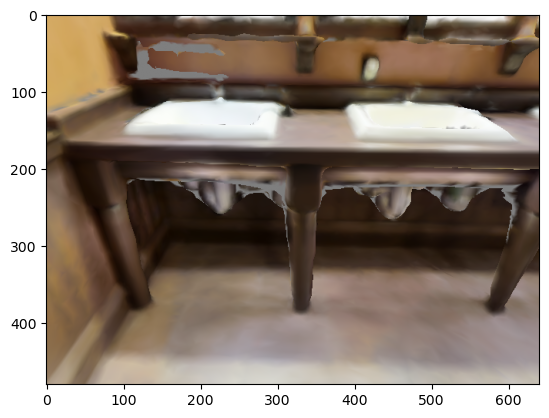

In [65]:
plt.imshow(img[0, ..., :3].cpu().detach().numpy())

In [27]:
obj_img = renderer(meshes_world=obj_mesh, cameras=camera)

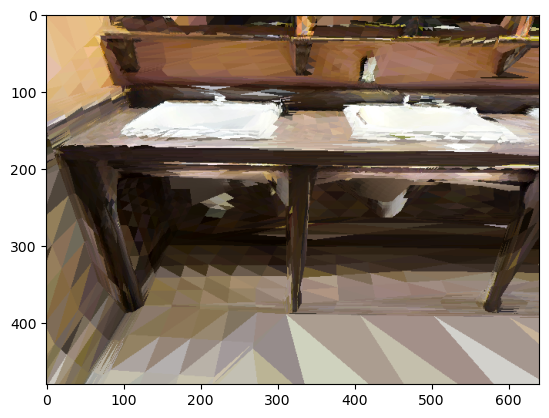

In [28]:
plt.imshow(obj_img[0, ..., :3].cpu().detach().numpy())

In [70]:
from render.utils import read_image

In [80]:
import os
from PIL import Image
def read_image(scan, vp, heading, elevation, display=False):
    # find image and display for compare
    img_path = os.path.join(
        '/home/zijiao/research/pytorch_rend/render_example/save/images/val_seen', scan, f"{scan}_{vp}_{heading}_{elevation}.png"
    )
    img = Image.open(img_path)
    print("Image size:", img.size)
    if display:
        img.show()
    return img

In [81]:
float(heading[0])

0.0

In [82]:
float(elevation[0])

-0.5235987755982988

In [83]:
img  = read_image(scan, vp, float(heading[0]), float(elevation[0]), display=True)

Image size: (640, 480)


Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)


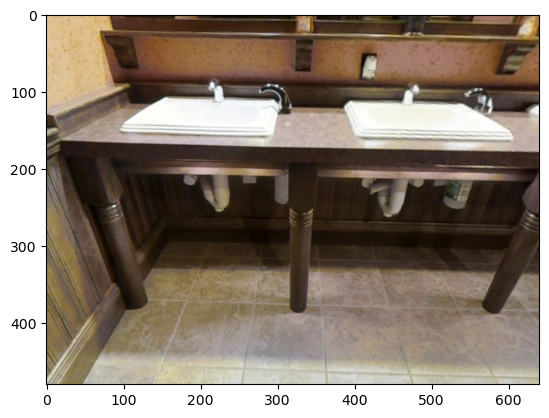

In [84]:
plt.imshow(img)

In [66]:
from pytorch3d.io import load_obj
verts, faces, aux = load_obj(
    '/mnt/sw/data/vln/traj/data/matterport3d/mp3d_mesh/v1/scans/r1Q1Z4BcV1o/matterport_mesh/ec72ed7d211541abbdf96faee1d049e3/ec72ed7d211541abbdf96faee1d049e3.obj',
    load_textures=True,
    create_texture_atlas=True,
    texture_wrap="clamp",
    texture_atlas_size=20,
)